# Introduction

This notebook uses PV panel production as an example to show how to implement regionalized version of ecoinvent in LCA studies.

# Table of content <a id='back'></a>
    
   <a href='#import'>Preparation: Import packages and files; prepare indexes for tracing contributors</a> <br>

1. <a href='#step1'>How to do LCA calculation? </a> <br>
2. <a href='#step2'>How to get country or sector contributions to total impact? </a> <br>
3. <a href='#step3'>How to dig deeper and find out key processes and locations? </a> <br>
4. <a href='#step4'>How to trace the country-level consumption mixes of products based on IOT? </a> <br>



## Preparation: Import packages and files; prepare indexes for tracing contributors <a id='import'></a> <br>
 <a href='#back'>back</a> 

In [2]:
import os
import pickle
import collections
import operator
import time
import itertools
import textwrap

import brightway2 as bw
import numpy as np
import scipy.sparse as sp
import pypardiso as pp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns 
%matplotlib inline

import geopandas as gpd
import matplotlib as mpl

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


In [4]:
with open('../../Data/final_matrix/full_index.p', 'rb') as i:
    full_index = pickle.load(i)
with open('../../Data/final_matrix/technosphere_matrix.p', 'rb') as i:
    tec_mat = pickle.load(i)
with open('../../Data/final_matrix/biosphere_index.p', 'rb') as i:
    bio_index = pickle.load(i)
with open('../../Data/final_matrix/biosphere_matrix_csc.p', 'rb') as i:
    bio_mat = pickle.load(i)

In [5]:
cfs_dict = {}
with open('../../Data/final_matrix/CF_aware_glo.p', 'rb') as i:
    cfs_dict['aware_glo'] = pd.read_pickle(i)
with open('../../Data/final_matrix/CF_aware.p', 'rb') as i:
    cfs_dict['aware_reg'] = pd.read_pickle(i)
with open('../../Data/final_matrix/CF_ipcc.p', 'rb') as i:
    cfs_dict['ipcc'] = pd.read_pickle(i)

In [6]:
cfs_ei_dict = {}
with open('../../Data/final_matrix/CF_aware_glo_eco.p', 'rb') as i:
    cfs_ei_dict['aware_glo_ei'] = pd.read_pickle(i)

In [7]:
with open('../../Data/tech_vector/full_reference_dataset_dict.p', 'rb') as i: #{full_index: code of ref ds}
    ref_ds_dict = pickle.load(i)
inv_ref_ds_dict = collections.defaultdict(dict)
for full_i, ref_ds in ref_ds_dict.items():
    inv_ref_ds_dict[ref_ds][full_i[0]] = full_i
inv_ref_ds_dict = dict(inv_ref_ds_dict) #{code:{reg: (reg, mr_key)}}

with open('../../Data/tech_vector/mr_key_MRD.p', 'rb') as i:
    mr_key_MRD = pickle.load(i)

In [8]:
with open('../../Data/region_matching/iot_co.p', 'rb') as i:
    iot_co = pickle.load(i)
with open('../../Data/lci_iot_imported/iot_flow.p', 'rb') as i:
    iot = pickle.load(i)
iot_sectors = np.array(iot.index.levels[1])

In [9]:
with open('../../Data/sector_matching/isic_TO_exio_name.p', 'rb') as i:
    isic_TO_exio_name = pickle.load(i)
with open('../../Data/tech_vector/datasets_no_prodmix_with_new_items.p', 'rb') as i:
    datasets = pickle.load(i)

In [10]:
%%time
bw.projects.set_current('regeco')
bw.projects.current
db = bw.Database('ecoinvent 3.7.1_cutoff_ecoSpold02')

CPU times: user 44.7 ms, sys: 13.9 ms, total: 58.6 ms
Wall time: 146 ms


Based on the full index list which characterizes datasets in new ecoinvent and descbribes rows and columns of technosphere matrix, we generate corresponding country list, isic sector list, dataset name list, reference product list, unit list, and reference dataset location list. These lists are used for contribution analysis based on characterized inventory matrix in the future.

In [89]:
full_index_country = [(i[0][:2],i[1]) if i[0] != 'Canada without Quebec' else ('CA',i[1])  for i in full_index]
with open('../../Data/lcia_case_studies/full_index_country.p', 'wb') as o:
    pickle.dump(full_index_country, o)

In [ ]:
# full_index_isic_sector. full_index -> code of ref ds -> isic code -> isic name

# isic code to name
isic_code_to_name = {}
for ds in datasets:
    cl = ds['classifications']
    isic_code_to_name[ds['ISIC code']] = [c[1] for c in cl if c[0].startswith('ISIC')][0].split(':')[1]

with open('../../Data/lcia_case_studies/isic_code_to_name.p', 'wb') as o:
    pickle.dump(isic_code_to_name, o)

ei_ds_TO_isic_code = {d['code']: d['ISIC code'] for d in datasets}
full_index_TO_isic_name = {ind: isic_code_to_name[ei_ds_TO_isic_code[ref_ds_dict[ind]]] for ind in full_index}
full_index_isic_sector = [sec for ind, sec in full_index_TO_isic_name.items()]

with open('../../Data/lcia_case_studies/full_index_isic_sector.p', 'wb') as o:
    pickle.dump(full_index_isic_sector, o)

In [ ]:
full_index_referprod = [db.get(ref_ds_dict[tuple(i)]).as_dict()['reference product'] for i in full_index]
with open('../../Data/lcia_case_studies/full_index_referprod.p', 'wb') as o:
    pickle.dump(full_index_referprod, o)

In [ ]:
full_index_unit = [db.get(ref_ds_dict[tuple(i)]).as_dict()['unit'] for i in full_index]
with open('../../Data/lcia_case_studies/full_index_unit.p', 'wb') as o:
    pickle.dump(full_index_unit, o)

In [ ]:
full_index_ref_loc = [db.get(ref_ds_dict[tuple(i)]).as_dict()['location'] for i in full_index]
with open('../../Data/lcia_case_studies/full_index_ref_loc.p', 'wb') as o:
    pickle.dump(full_index_ref_loc, o)

## 1. How to do LCA calculation?<a id='step1'></a> <br>
 <a href='#back'>back</a> 

We use the PyPardiso library developed by Haas (2016) to factorize the technosphere matrix once and then efficiently solve $(I-A)×x=y$ to get accumulated supply vectors $y$ for different demand vectors $x$. 

In [12]:
solver = pp.PyPardisoSolver()
%time solver.factorize(tec_mat)

CPU times: user 3h 19min 4s, sys: 53 s, total: 3h 19min 57s
Wall time: 6min 44s


In [13]:
class RegionalizedLCA:
    '''
    Implement the regionalized version of ecoinvent to do a LCA study for a specific demand.
    
    '''
    def __init__(self, demand, method=None, solver=None):
        self.demand = demand
        self.method = method
        self.solver = solver
        self.technosphere_matrix = tec_mat
        self.biosphere_matrix = bio_mat
        self.full_index = full_index
        self.full_index_country = full_index_country
        self.full_index_isic_sector = full_index_isic_sector
        
        self.regions = sorted(list({i[0] for i in self.full_index_country}))  # for supply side aggregation
        self.sectors = sorted(list({i for i in self.full_index_isic_sector})) # 92 supply sectors
        self.region_id_mask = np.array([self.regions.index(r[0]) for r in self.full_index_country])
        self.sector_id_mask = np.array([self.sectors.index(r) for r in self.full_index_isic_sector])
        self.cfs = cfs_dict
        self.cfs_ei = cfs_ei_dict
        self.inv_ref_ds_dict = inv_ref_ds_dict
        
    def build_demand_array(self):
        demand_arr = np.zeros(self.technosphere_matrix.shape[0])
        for i, v in self.demand.items():
            demand_arr[self.full_index.index(i)] = v
        return demand_arr
    
    def lci(self):
        demand = self.build_demand_array()
        self.supply = solver.solve(self.technosphere_matrix, demand)
    
    def lcia(self):
        if not self.method:
            raise UserWarning('must choose method')
        self.inventory = self.biosphere_matrix *sp.diags(self.supply)
        cf_mat = self.cfs[self.method]
        if operator.eq(*cf_mat.shape):
            self.characterized_inventory = cf_mat*self.inventory #non-regionalized
        else:
            self.characterized_inventory = cf_mat.multiply(self.inventory) #regionalized
    
    def supply_country_aggregated_ChInventory(self):#aggregated by producer/supply co
        inventory_agg = np.array(self.characterized_inventory.sum(axis=0)).squeeze()
        country_agg = np.bincount(self.region_id_mask, weights=inventory_agg) 
        return country_agg
    
    def supply_sector_aggregated_ChInventory(self):#aggregated by producer/supply sectors
        inventory_agg = np.array(self.characterized_inventory.sum(axis=0)).squeeze()
        sector_agg = np.bincount(self.sector_id_mask, weights=inventory_agg) 
        return sector_agg
    
    def multi_inventory(self, region):
        region_indices = [i for i, ind in enumerate(self.full_index) if ind[0]==region]
        demand = np.zeros((self.technosphere_matrix.shape[0], len(region_indices)))
        for i, ri in enumerate(region_indices):
            demand[ri,i] = 1
        supply = self.solver.solve(self.technosphere_matrix, demand)
        return supply
    
    def switch_method(self, method):
        assert method in self.cfs, f'{method} not available'
        self.method = method
    
    def lcia_all(self):
        scores_dict = {}
        for method in self.cfs:
            self.switch_method(method)
            self.lcia()
            scores_dict[method] = self.characterized_inventory.sum()
        return scores_dict
    
    def ecoinvent_comparison(self, activity):
        ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')
        eco_lca = bw.LCA({activity:1}, ipcc)
        eco_lca.lci()
        eco_lca.lcia()
        eco_res = {}
        eco_res['ipcc'] = eco_lca.score
        inv = eco_lca.inventory
        for met in self.cfs_ei:
            ChaInv = self.cfs_ei[met]*inv 
            eco_res[met] = ChaInv.sum()
        res = {}
        name = 'ecoinvent' + ' '+ activity.as_dict()['location']
        res[name] = eco_res
        for region, ind in self.inv_ref_ds_dict[activity.key[1]].items():# for consumer side
            self.demand = {ind: 1}
            self.lci()
            scores = self.lcia_all()
            res[region] = scores #for specific ds, not all final location have it
        return res

In [14]:
pv_panel = db.search('photovoltaic panel production, single-Si wafer')
pv_panel

['photovoltaic panel production, single-Si wafer' (square meter, RER, None),
 'photovoltaic panel production, single-Si wafer' (square meter, RoW, None),
 'photovoltaic laminate production, single-Si wafer' (square meter, RER, None),
 'photovoltaic laminate production, single-Si wafer' (square meter, RoW, None)]

In [15]:
demand = {('CH', '00e4a6354bc9c5d21e73d00730e50071'): 1} #use a random dataset in new ecoinvent to set up the calculation
lca = RegionalizedLCA(demand=demand, method='ipcc')
%time lca.lci()

CPU times: user 39 s, sys: 31 s, total: 1min 10s
Wall time: 4.37 s


In [16]:
%time panel_res = lca.ecoinvent_comparison(pv_panel[0])
res_df0 = pd.DataFrame(panel_res)
res_df0

CPU times: user 17min 23s, sys: 9min 22s, total: 26min 45s
Wall time: 1min 41s


,ecoinvent RER,LV,LU,IT,BG,SK,HR,HU,PT,LT,...,SE,IE,EE,MT,BE,RO,SI,CH,ES,PL
ipcc,265.881339,226.906462,228.690184,270.620214,249.451734,267.961357,272.793832,257.189240,208.234422,263.225684,...,215.273852,228.241227,264.576403,232.339142,258.034160,251.616835,259.175094,251.480858,266.359898,285.570571
aware_glo_ei,331.623317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aware_glo,NaN,369.428651,323.702258,326.093029,338.509376,357.156839,327.548620,331.675811,322.126697,340.370825,...,324.844424,317.772417,337.005361,330.458928,322.158788,341.161529,333.575624,330.646906,323.956410,336.020593
aware_reg,NaN,107.297569,141.718306,203.918856,157.943173,169.882334,199.757631,174.855827,223.643889,170.249598,...,129.351423,143.392134,172.498628,180.139991,179.761194,164.535101,175.041166,170.735926,205.057505,203.039449


In [17]:
%time panel_res = lca.ecoinvent_comparison(pv_panel[1])
res_df1 = pd.DataFrame(panel_res)
res_df1

CPU times: user 8min 42s, sys: 4min 58s, total: 13min 40s
Wall time: 51.6 s


,ecoinvent RoW,MX,TW,BR,ID,TR,CY,US,AU,CA,IN,CN,RU,ZA,JP,KR
ipcc,266.199490,267.907386,262.616633,205.679034,281.171283,289.159934,249.229115,279.940001,304.392130,269.811557,315.439540,328.745717,272.830809,301.857473,264.135849,287.465436
aware_glo_ei,330.901043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aware_glo,NaN,312.506283,314.878061,398.933847,310.764570,319.778386,327.174043,313.537142,310.380124,323.222442,305.118404,307.370068,336.851482,327.155941,305.518815,312.693177
aware_reg,NaN,234.971233,176.904681,141.367553,199.807266,226.176576,167.691569,238.224471,248.503751,234.655356,203.588008,262.297672,195.539773,202.613095,61.319555,185.086318


In [44]:
res_df = pd.concat([res_df0, res_df1], axis=1)
res_df = res_df[sorted(res_df.columns.tolist())]
res_df.to_csv('../../Data/lcia_case_studies/PV_panel/PV_panel_ipcc_all_co.csv')

Let us visualize the impact results on a map or on a bar plot:

In [46]:
res_df_map = res_df.T
res_df_map = res_df_map.drop(res_df_map.index[0])
res_df_map['ipcc_relative'] = res_df_map['ipcc']/(res_df_map['ipcc']['ecoinvent RER']+res_df_map['ipcc']['ecoinvent RoW'])*2
res_df_map = res_df_map.drop(['ecoinvent RER','ecoinvent RoW']).reset_index().rename(columns = {'index':'Two_Letter_Country_Code'})
res_df_map

,Two_Letter_Country_Code,ipcc,aware_glo_ei,aware_glo,aware_reg,ipcc_relative
0,AU,304.392130,NaN,310.380124,248.503751,1.144157
1,BE,258.034160,NaN,322.158788,179.761194,0.969906
2,BG,249.451734,NaN,338.509376,157.943173,0.937646
3,BR,205.679034,NaN,398.933847,141.367553,0.773112
4,CA,269.811557,NaN,323.222442,234.655356,1.014175
5,CH,251.480858,NaN,330.646906,170.735926,0.945273
6,CN,328.745717,NaN,307.370068,262.297672,1.235698
7,CY,249.229115,NaN,327.174043,167.691569,0.936809
8,CZ,289.729676,NaN,343.916500,198.651501,1.089044
9,DE,275.074818,NaN,326.795598,190.287047,1.033959


In [48]:
country_code = pd.read_excel('../../Data/other_data/country-and-continent-codes-list-added-ME.xlsx',engine='openpyxl')
country_code = country_code[['Two_Letter_Country_Code','Three_Letter_Country_Code']]

In [49]:
res_df_3_code = res_df_map.merge(country_code, how='left', on='Two_Letter_Country_Code')
#there are double RU
res_df_3_code = res_df_3_code.drop(res_df_3_code.index[res_df_3_code['Two_Letter_Country_Code'] == 'RU'][0]).reset_index(drop=True)
res_df_3_code = res_df_3_code.rename(columns = {'Three_Letter_Country_Code':'iso_a3'})
res_df_3_code

,Two_Letter_Country_Code,ipcc,aware_glo_ei,aware_glo,aware_reg,ipcc_relative,iso_a3
0,AU,304.392130,NaN,310.380124,248.503751,1.144157,AUS
1,BE,258.034160,NaN,322.158788,179.761194,0.969906,BEL
2,BG,249.451734,NaN,338.509376,157.943173,0.937646,BGR
3,BR,205.679034,NaN,398.933847,141.367553,0.773112,BRA
4,CA,269.811557,NaN,323.222442,234.655356,1.014175,CAN
5,CH,251.480858,NaN,330.646906,170.735926,0.945273,CHE
6,CN,328.745717,NaN,307.370068,262.297672,1.235698,CHN
7,CY,249.229115,NaN,327.174043,167.691569,0.936809,CYP
8,CZ,289.729676,NaN,343.916500,198.651501,1.089044,CZE
9,DE,275.074818,NaN,326.795598,190.287047,1.033959,DEU


In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#the iso_a3 of following three countries are -99
world.at[world.index[world['name'] == 'Norway'], 'iso_a3'] = 'NOR'
world.at[world.index[world['name'] == 'France'], 'iso_a3'] = 'FRA'
world.at[world.index[world['name'] == 'Cyprus'], 'iso_a3'] = 'CYP'
world_merge = world.merge(res_df_3_code[['ipcc_relative','iso_a3']], how='left', on='iso_a3')

# fill na with 999 first, then later change it back to na. otherwise, affect plotting: cannot norm + discrete legend
world_merge['ipcc_relative'] = world_merge['ipcc_relative'].fillna(999)

# #drop ATA
world['ipcc_relative'] = world_merge['ipcc_relative']
world["ipcc_relative"] = world.ipcc_relative.apply(lambda x: x if x !=999 else np.nan)
world = world.drop(world.index[world['iso_a3'] == 'ATA']).reset_index(drop=True)
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,ipcc_relative
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",1.014175
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1.052246
...,...,...,...,...,...,...,...
171,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",NaN
172,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",NaN
173,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN
174,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",NaN


In [51]:
# Malta is not in gpd. 
set(res_df_3_code['iso_a3']) - set(world_merge['iso_a3'])-set(world_merge[world_merge.ipcc_relative.isna()]['iso_a3'])  

{'MLT'}

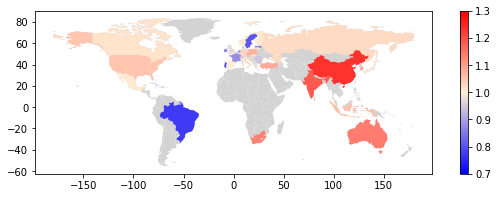

In [52]:
# create a colormap and norm
colors = [(0, 0, 1), 'papayawhip', (1, 0, 0)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, N=256)
norm = mpl.colors.TwoSlopeNorm(vcenter=1, vmin=0.7, vmax=1.3) 

fig, ax1 = plt.subplots(1,1, figsize = (10,3)) 
# fig.suptitle('Regional impact based on regionalized ecoivent / RoW(/RER) impact based on ecoinvent',
#              fontsize = 'x-large', fontweight = 'bold')
    
world.plot(color = "lightgrey", ax = ax1)
world.dropna().plot(column = 'ipcc_relative',cmap = cmap,norm = norm,ax = ax1,legend = True)

fig.savefig('../../Data/lcia_case_studies/PV_panel/PV_panel_impact_pv_reg_comparison_map.png',dpi=300)

In [53]:
PV_panel_ipcc = res_df.loc['ipcc']
pv_regions = sorted(PV_panel_ipcc.keys())
pv_regions = [i for i in pv_regions if 'ecoinvent' not in i]

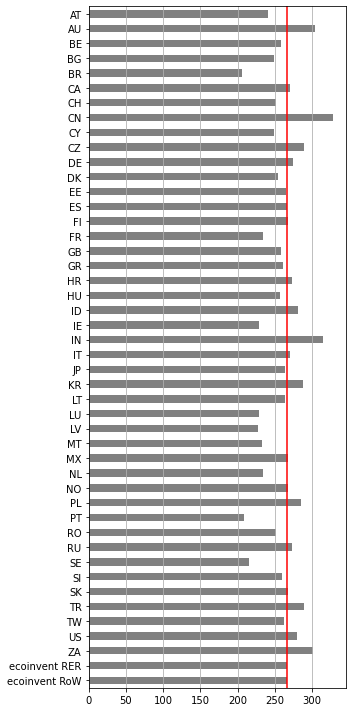

In [65]:
fig, ax = plt.subplots(figsize=(5, 10))
PV_panel_ipcc.plot(kind='barh',x='name',y='num_pets', color='grey', ax=ax)
ax.vlines(PV_panel_ipcc['ecoinvent RER'], *ax.get_ylim(), color='red', label='ecoinvent RER')
ax.invert_yaxis()
ax.grid(axis='x', which='major', zorder=0)
fig.tight_layout()
# fig.savefig('../../Data/lcia_case_studies/PV_panel/PV_panel_impact_pv_reg_comparison.png')

## 2. How to get country or sector contributions to total impact?<a id='step2'></a> <br>
 <a href='#back'>back</a> 

In [66]:
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

In [67]:
# define target regions (full_index)
PV_panel_regions1 = [lca.inv_ref_ds_dict[pv_panel[1].key[1]][r] for r in ('CN', 'JP')]
PV_panel_regions2 = [lca.inv_ref_ds_dict[pv_panel[0].key[1]]['DE']]
PV_panel_regions = PV_panel_regions1 + PV_panel_regions2
PV_panel_regions

[('CN', 'f541f67229f7b52b5386e96bc5a629c6'),
 ('JP', 'f541f67229f7b52b5386e96bc5a629c6'),
 ('DE', 'f541f67229f7b52b5386e96bc5a629c6')]

In [69]:
%%time
sup_reg_dict = {}
sup_sec_dict = {}
for panel in PV_panel_regions:
    lca.demand = {panel: 1}
    lca.lci()
    res_reg = {}
    res_sec = {}
    with open('../../Data/lcia_case_studies/PV_panel/PV_panel_supply_'+panel[0]+'.p', 'wb') as o:
        pickle.dump(lca.supply, o)
    for method in ['ipcc']:
        lca.switch_method(method)
        lca.lcia()
        with open('../../Data/lcia_case_studies/PV_panel/PV_panel_characterized_inventory_'+method+'_'+panel[0]+'.p', 'wb') as o:
            pickle.dump(lca.characterized_inventory, o)
        res_reg[method] = pd.Series(lca.supply_country_aggregated_ChInventory(), index=lca.regions)
        res_sec[method] = pd.Series(lca.supply_sector_aggregated_ChInventory(), index=lca.sectors)
        
    sup_reg_dict[panel[0]] = pd.DataFrame(res_reg)
    sup_sec_dict[panel[0]] = pd.DataFrame(res_sec)

CPU times: user 1min 51s, sys: 1min 13s, total: 3min 5s
Wall time: 10.5 s


In [70]:
for reg in ('CN', 'JP', 'DE'):
    df = sup_reg_dict[reg]
    df.to_csv('../../Data/lcia_case_studies/PV_panel/PV_panel_impact_supplychain_region_'+reg+'.csv')

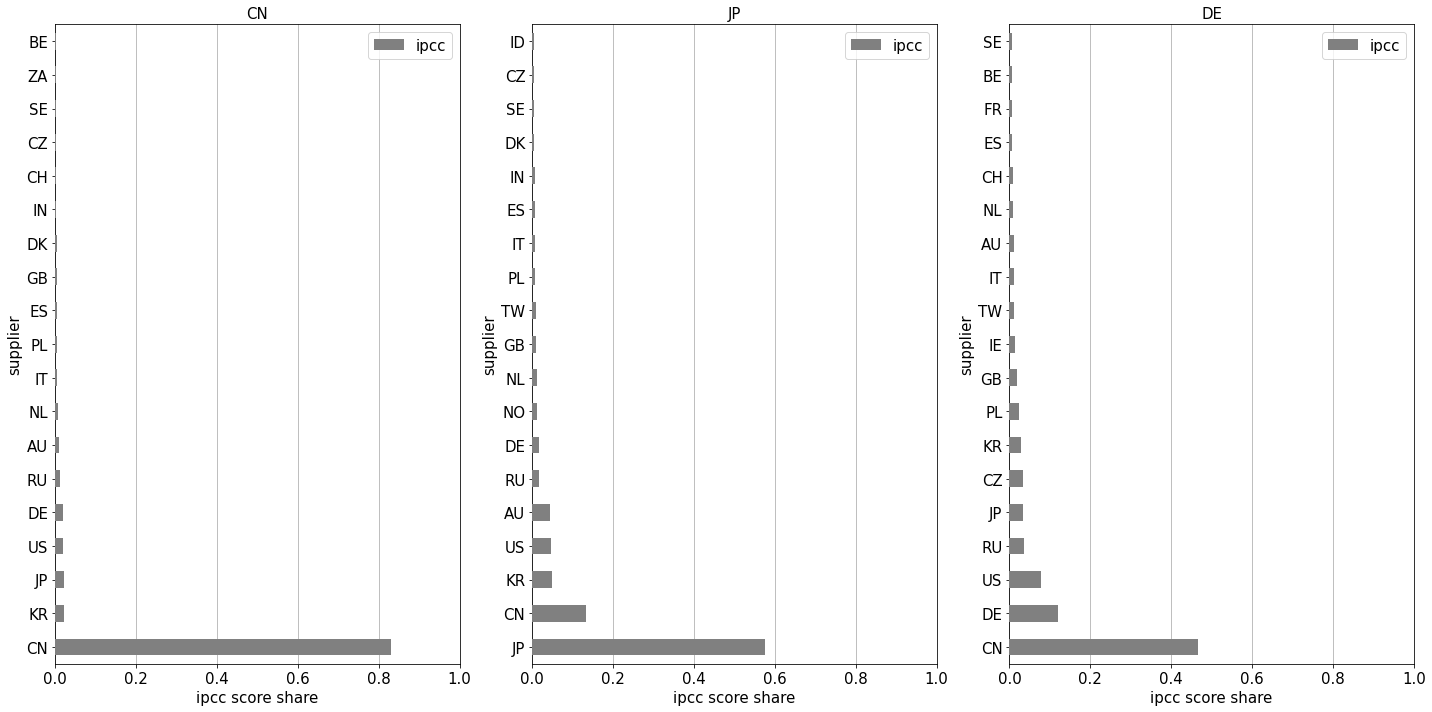

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=False)
met = 'ipcc'

for ax, reg in zip(axes, ('CN', 'JP', 'DE')):
    df = sup_reg_dict[reg]
    sup_rel = df/df.sum(axis=0)
    data_fig = sup_rel[met].sort_values(ascending=False)[0:19]
    data_fig.plot(kind='barh', ax=ax, color='grey', label=met, zorder=3)
    ax.legend(loc='upper right',fontsize = 15)
    ax.grid(axis='x', which='major', zorder=0)
    ax.set_title(reg,fontsize = 15)
    ax.set_xlabel('ipcc score share', fontsize = 15)
    ax.set_ylabel('supplier', fontsize = 15)
    ax.tick_params(axis='both', labelsize=15)
    if met == 'ipcc':
        ax.set_xlim([0, 1])
    else:
        ax.set_xlim([0, 0.8])
# fig.savefig('../../Data/lcia_case_studies/PV_panel/PV_panel_impact_supplychain_region_'+met+'.png')
fig.tight_layout()

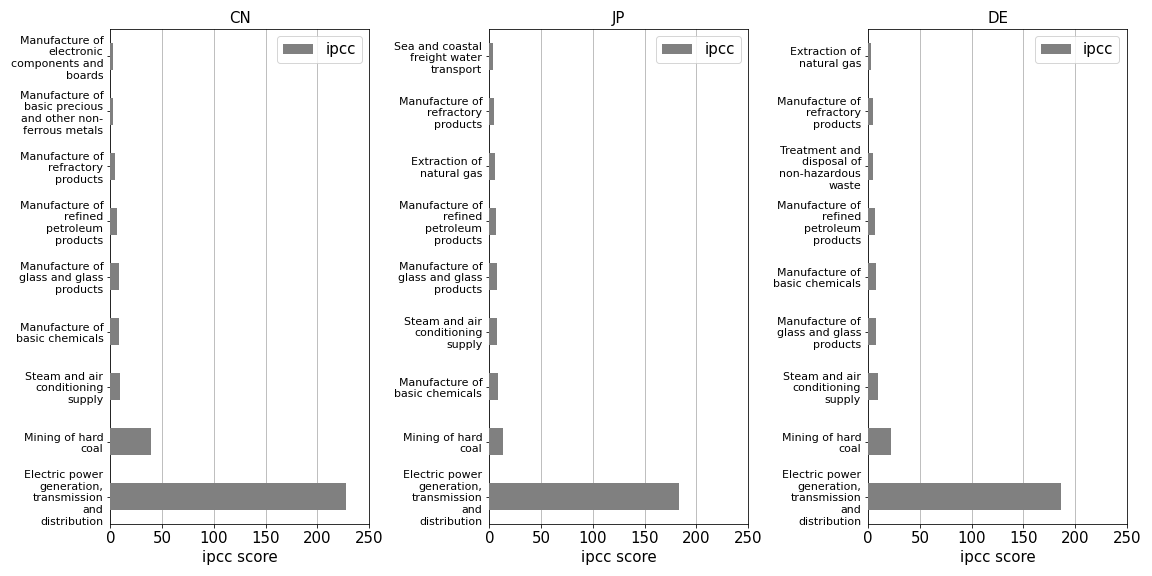

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=False)
met = 'ipcc'

for ax, reg in zip(axes, ('CN', 'JP', 'DE')):
    df = sup_sec_dict[reg]
#     sup_rel = df/df.sum(axis=0)
    sup_rel = df
    data_fig = sup_rel[met].sort_values(ascending=False)[0:9]
    data_fig.plot(kind='barh', ax=ax, color='grey', label=met, zorder=3)
    ax.legend(loc='upper right', fontsize = 15)
    ax.grid(axis='x', which='major', zorder=0)
    ax.set_yticklabels([textwrap.fill(e, 15) for e in data_fig.keys()])
    ax.set_title(reg, fontsize = 15)
#     ax.set_xlabel('ipcc score share', fontsize = 15)
    ax.set_xlabel('ipcc score', fontsize = 15)
#     ax.set_ylabel('supplier', fontsize = 15)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=11)
    if met == 'ipcc':
#         ax.set_xlim([0, 0.8])#0.45 3
        ax.set_xlim([0, 250])
    else:
#         ax.set_xlim([0, 15]) #0.3 5
        ax.set_xlim([0, 0.4])
    
# fig.savefig('../../Data/lcia_case_studies/PV_panel/PV_panel_impact_supplychain_sector_'+met+'.png')
fig.savefig('../../Data/lcia_case_studies/PV_panel/PV_panel_absolute_impact_supplychain_sector_'+met+'.png')
fig.tight_layout()

## 3. How to dig deeper and find out key processes and locations?<a id='step3'></a> <br>
 <a href='#back'>back</a> 

In [75]:
ipcc_per_FU = cfs_dict['ipcc']*bio_mat
ipcc_per_FU = np.array(ipcc_per_FU.sum(axis=0)).squeeze()

In [92]:
# check top 20 datasets as contributors
with pd.ExcelWriter("../../Data/lcia_case_studies/PV_panel/ipcc_top_ds_infor.xlsx") as writer: 
    ipcc_top = pd.DataFrame() 
    for co in ['CN', 'JP', 'DE']:
        with open('../../Data/lcia_case_studies/PV_panel/PV_panel_characterized_inventory_ipcc_'+co+'.p', 'rb') as i:
            CHinvent = pickle.load(i)
        CHinvent_sum = np.array(CHinvent.sum(axis=0)).squeeze()

        ind_max = CHinvent_sum.argsort()[-20:][::-1] #get index of sorted values /Descending
        score_max = [CHinvent_sum[i] for i in ind_max]
        full_ind_max = tuple(np.array(full_index)[ind_max])
        ds_name_max = [full_index_dsname[i] for i in ind_max]
        ds_loc_max = [full_index_ref_loc[i] for i in ind_max]
        co_max = [full_index_country[i][0] for i in ind_max]
        refprod_max = [full_index_referprod[i] for i in ind_max]
        ds_unit_max = [full_index_unit[i] for i in ind_max]
        sec = [full_index_isic_sector[i] for i in ind_max]

        score_per_FU_max = [ipcc_per_FU[i] for i in ind_max]
        with open('../../Data/lcia_case_studies/PV_panel/PV_panel_supply_'+co+'.p', 'rb') as i:
            supply_ar = pickle.load(i)
        supply_l = [supply_ar[i] for i in ind_max]
        print(len(ind_max), len(supply_l))

        consume_co = [co for i in ind_max]

        df = pd.DataFrame({'consumer':consume_co,
                           'full index':full_ind_max,
                           'supply country':co_max,
                           'dataset name':ds_name_max,
                           'dataset location':ds_loc_max,
                           'reference product':refprod_max,
                           'unit':ds_unit_max,
                           'ipcc score per FU':score_per_FU_max,
                           'ipcc score':score_max,
                           'accumulated supply': tuple(supply_l),
                           'ISIC classification': sec}) 
        ipcc_top = pd.concat([ipcc_top,df])

    idx = pd.MultiIndex.from_product([['CN', 'JP', 'DE'],list(range(len(ind_max)))],names=['Country', 'Maximum'])
    ipcc_top = ipcc_top.set_index(idx)
    ipcc_top['accumulated supply calculated'] = ipcc_top['ipcc score']/ipcc_top['ipcc score per FU'] 
    ipcc_top.to_excel(writer) 

20 20
20 20
20 20


In [93]:
# check 5 top co-isic combinations  as contributors
def get_top_co_isic(co):
    with open('../../Data/lcia_case_studies/PV_panel/PV_panel_characterized_inventory_ipcc_'+co+'.p', 'rb') as i:
        CHinvent = pickle.load(i)
    CHinvent_sum = np.array(CHinvent.sum(axis=0)).squeeze()
    consume_co = [co for i in CHinvent_sum]
    supply_co = [i[0] for i in full_index_country]
    df_all = pd.DataFrame({'consumer':consume_co,
                       'full index':full_index,
                       'supply country':supply_co,
                       'dataset name':full_index_dsname,
                       'dataset location':full_index_ref_loc,
                       'reference product':full_index_referprod,
                       'unit':full_index_unit,
                       'ipcc score':CHinvent_sum,
                       'ISIC classification': full_index_isic_sector}) 
    
    df_co_isic = df_all.groupby(['supply country','ISIC classification'])['ipcc score'].sum().reset_index()
    df_co_isic = df_co_isic.sort_values(by=['ipcc score'], ascending=False).reset_index(drop=True)
    df_top = df_co_isic[:5]
    df_top.loc[len(df_top.index)] = ['Others', '', df_all['ipcc score'].sum()-df_top['ipcc score'].sum()] 
    return df_all,df_top

In [16]:
df_all_CN,df_top_CN = get_top_co_isic('CN')
df_all_DE,df_top_DE = get_top_co_isic('DE')
df_all_JP,df_top_JP = get_top_co_isic('JP')
df_top_CN



,supply country,ISIC classification,ipcc score
0,CN,"Electric power generation, transmission and di...",193.609985
1,CN,Mining of hard coal,37.257027
2,CN,Manufacture of glass and glass products,7.636771
3,CN,Steam and air conditioning supply,6.944842
4,CN,Manufacture of basic chemicals,6.078393
5,Others,,77.218699


In the top 5 combinations of country-sector, we can observe that 'Electric power generation, transmission and distribution' (Hereafter simply power sector) in certain countries keep dominating the GWP: 
- For Chinese PV panel production, Chinese power sector contributes most. 
- For German PV panel production, Chinese and German power sectors contribute most. 
- For Japanese PV panel production, Japanese and Chinese power sectors contribute most.

Next, we disaggregate these regional power sectors into regional electricity production processes. The main electricity sources in each country can be gained from market composition data from ecoinvent.

In [96]:
elec_type_name = {'Electricity production, lignite':('electricity production, lignite','heat and power co-generation, lignite'),
                  'Electricity production, coal':('electricity production, coal','electricity production, hard coal','heat and power co-generation, hard coal'),
                  'Electricity production, natural gas':('electricity production, natural gas','heat and power co-generation, natural gas')
                  }
# 'Electricity production, hydro':'electricity production, hydro' is main source but not considered due to low GWP

def disaggre_elec_of_co(df_all, df_top, elec_sup_co):
    df_elec = df_all[(df_all['supply country']==elec_sup_co)&(df_all['ISIC classification']=='Electric power generation, transmission and distribution')]
    
    df_elec_plot = pd.DataFrame(columns=['supply country','ISIC classification','ipcc score']) 
    for k in elec_type_name.keys():
        if elec_sup_co!='DE' and k=='Electricity production, lignite': # some unimportant regional processes we want to skip
            continue
        if elec_sup_co=='DE' and k=='Electricity production, natural gas':
            continue
        elec_k = df_elec[(df_elec['unit']=='kilowatt hour')&[i.startswith(elec_type_name[k]) for i in df_elec['dataset name']]]
        df_elec_plot.loc[len(df_elec_plot.index)] = [elec_sup_co, k, elec_k['ipcc score'].sum()]
    df_elec_plot.loc[len(df_elec_plot.index)] = [elec_sup_co, 'Electricity activities, others', 
                                                 df_elec['ipcc score'].sum()-df_elec_plot['ipcc score'].sum()]   
    
    # summarize key processes in regional power sector + other top 5 regional sectors
    bound = df_top.index[(df_top['supply country']==elec_sup_co)&(df_top['ISIC classification']=='Electric power generation, transmission and distribution')].tolist()[0]
    df_plot1 = df_top.iloc[:bound]
    df_plot2 = df_top.iloc[(bound+1):]
    df_after_disaggre = pd.concat([df_plot1,df_elec_plot,df_plot2]) 
    df_after_disaggre = df_after_disaggre.reset_index(drop=True)
    return df_after_disaggre


In [97]:
df_plot_CN = disaggre_elec_of_co(df_all_CN, df_top_CN,'CN').rename(columns={"ipcc score": "China"}).set_index(['supply country','ISIC classification'])

df_plot_DE = disaggre_elec_of_co(df_all_DE, df_top_DE,'DE')
df_plot_DE = disaggre_elec_of_co(df_all_DE, df_plot_DE,'CN').rename(columns={"ipcc score": "Germany"}).set_index(['supply country','ISIC classification'])

df_plot_JP = disaggre_elec_of_co(df_all_JP, df_top_JP,'JP')
df_plot_JP = disaggre_elec_of_co(df_all_JP, df_plot_JP,'CN').rename(columns={"ipcc score": "Japan"}).set_index(['supply country','ISIC classification'])

In [17]:
df_plot = pd.concat([df_plot_JP, df_plot_DE, df_plot_CN], axis=1)
df_plot = df_plot.reindex(["CN", "JP", "DE", 'US','IN', 'AU','Others'], axis=0, level=0)
df_plot.to_csv('../../Data/lcia_case_studies/PV_panel/PV_panel_ipcc_CN_JP_DE.csv')
df_plot

Japan  \
supply country ISIC classification                                             
CN             Electricity activities, others                       0.975947   
               Electricity production, coal                        22.449470   
               Electricity production, natural gas                  0.366726   
               Manufacture of basic chemicals                            NaN   
               Manufacture of glass and glass products                   NaN   
               Mining of hard coal                                       NaN   
               Steam and air conditioning supply                         NaN   
JP             Electric power generation, transmission and dis...        NaN   
               Electricity activities, others                      20.491397   
               Electricity production, coal                        60.615966   
               Electricity production, natural gas                 39.370112   
               Manufacture of glass and glass products              7.285544   
DE             Electricity activities, others                            NaN   
               Electricity production, coal                              NaN   
               Electricity production, lignite                           NaN   
US             Electric power generation, transmission and dis...   7.018861   
AU             Electric power generation, transmission and dis...   9.187043   
Others                                                             96.374784   

                                                                      Germany  \
supply country ISIC classification                                              
CN             Electricity activities, others                        3.507748   
               Electricity production, coal                         90.720856   
               Electricity production, natural gas                   1.517134   
               Manufacture of basic chemicals                             NaN   
               Manufacture of glass and glass products                    NaN   
               Mining of hard coal                                  18.503762   
               Steam and air conditioning supply                          NaN   
JP             Electric power generation, transmission and dis...    7.685905   
               Electricity activities, others                             NaN   
               Electricity production, coal                               NaN   
               Electricity production, natural gas                        NaN   
               Manufacture of glass and glass products                    NaN   
DE             Electricity activities, others                        2.344510   
               Electricity production, coal                          4.699959   
               Electricity production, lignite                       9.856092   
US             Electric power generation, transmission and dis...   15.191796   
AU             Electric power generation, transmission and dis...         NaN   
Others                                                             121.047056   

                                                                        China  
supply country ISIC classification                                             
CN             Electricity activities, others                        7.264094  
               Electricity production, coal                        183.241913  
               Electricity production, natural gas                   3.103977  
               Manufacture of basic chemicals                        6.078393  
               Manufacture of glass and glass products               7.636771  
               Mining of hard coal                                  37.257027  
               Steam and air conditioning supply                     6.944842  
JP             Electric power generation, transmission and dis...         NaN  
               Electricity activities, others    

## 4. How to trace the country-level consumption mixes of products based on IOT?<a id='step4'></a> <br>

Now, we already got LCA results of the target activity and need to trace the supply chain to explain the results. For example, we need to know why Chinese power production plays a key role in GWP caused by German PV panel production.  <br>
In this study, for a technosphere input into a dataset, the shares of its origins are mainly determined by the country-level consumption mixes from ecoinvent, which further affects the impact contributions of various regional processes. Thus, we need to get the country-level consumption mixes of relevant products (such as PV components and silicon) from EXIOBASE. <br>
Here, we use an example (how to get the German consumption mix of PV cells for PV panel production) to indicate the procedure.  

 <a href='#back'>back</a> 

In [99]:
# Step 1: get the exiobase sector of consumer
cons = db.search('photovoltaic panel production, single wafer')
print(cons[0].as_dict()['classifications'])

[('ISIC rev.4 ecoinvent', '2610:Manufacture of electronic components and boards'), ('EcoSpold01Categories', 'photovoltaic/production of components'), ('CPC', '47150: Diodes, transistors and similar semi-conductor devices; photosensitive semi-conductor devices; light emitting […]')]


In [101]:
def get_exio_sec_from_isic_code(isic_code):
    possible_full_isic_codes = [code for code in isic_TO_exio_name.keys() if code.startswith(isic_code)]
    exio_sec_name = list({sector for sector in itertools.chain.from_iterable([isic_TO_exio_name[c] for c in possible_full_isic_codes])})
    return exio_sec_name
    
isic_cons = '2610'
exio_sec_name_cons = get_exio_sec_from_isic_code(isic_cons)
exio_sec_name_cons

['Manufacture of office machinery and computers (30)']

In [102]:
# Step 2: get the exiobase sector of producer
prod = db.search('photovoltaic cell production, single-Si wafer')
print(prod[0].as_dict()['classifications'])

[('ISIC rev.4 ecoinvent', '2610:Manufacture of electronic components and boards'), ('EcoSpold01Categories', 'photovoltaic/production of components'), ('CPC', '47150: Diodes, transistors and similar semi-conductor devices; photosensitive semi-conductor devices; light emitting […]')]


In [103]:
prod_cons = '2610'
exio_sec_name_prod = get_exio_sec_from_isic_code(prod_cons)
exio_sec_name_prod

['Manufacture of office machinery and computers (30)']

In [110]:
# Step 3: get the import ratios
input_series = pd.DataFrame(index = iot.index)
for j in ['DE']:
    for i in exio_sec_name_cons:
        input_series = pd.concat([input_series,iot[j,i]], axis=1)
input_series = input_series.drop(labels=['WA','WE','WF','WL','WM'], level=0)
# input_series
input_certain = input_series.loc[(slice(None),exio_sec_name_prod),:]
input_certain_sum = input_certain.sum().sum()
import_ratio = {}
for co in iot_co:
    import_ratio[co]=input_certain.loc[co].sum().sum()/input_certain_sum
main_supplier = sorted(import_ratio.items(), key=lambda x: x[1], reverse=True)[:10]
main_supplier

[('CN', 0.3712145941886021),
 ('DE', 0.217577756234092),
 ('CZ', 0.1163014140176573),
 ('IE', 0.09041718334988708),
 ('US', 0.05157124567311561),
 ('HU', 0.02181725237897295),
 ('JP', 0.020803405877463606),
 ('KR', 0.019676169891146116),
 ('CH', 0.019074043903825087),
 ('TW', 0.017046105502151965)]

As we can see, Germany imports 37% of the PV cells from China. These values correspod to the values listed in the SI Table S2 of the publication.